## Library

In [1]:
!pip install gpytorch

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm
from skimage.transform import resize
import cv2
from typing import Type

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import torchvision.models as models

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

from torchvision import transforms
from scipy.ndimage import rotate
from skimage.transform import resize
from scipy.ndimage import gaussian_filter

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Init GPU

In [4]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: NVIDIA GeForce RTX 4070 SUPER is available.
cuda


In [5]:
%load_ext autoreload
%autoreload 2

## Config Info

In [6]:
# Constants
HEIGHT = 224
WIDTH = 224
CHANNELS = 3

TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
TEST_SIZE = 0.15
VALID_SIZE = 0.15

MAX_SLICES = 60
SHAPE = (HEIGHT, WIDTH, CHANNELS)

NUM_EPOCHS = 10
LEARNING_RATE = 5e-4
INDUCING_POINTS = 128

# TARGET_LABELS = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
TARGET_LABELS = ['intraparenchymal']

MODEL_PATH = 'results/trained_model.pth'
DEVICE = 'cuda'

In [7]:
# Kaggle and local switch
KAGGLE = os.path.exists('/kaggle')
print("Running on Kaggle" if KAGGLE else "Running locally")
ROOT_DIR = '/kaggle/input/' if KAGGLE else None
DATA_DIR = ROOT_DIR + 'rsna-mil-training/' if KAGGLE else '../rsna-mil-training/'
DICOM_DIR = DATA_DIR + 'rsna-mil-training/'
CSV_PATH = DATA_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_1000_scan_subset.csv'
SLICE_LABEL_PATH = ROOT_DIR + "sorted_training_dataset_with_labels.csv" if KAGGLE else './data_analyze/sorted_training_dataset_with_labels.csv'

dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR
# Load patient scan labels
patient_scan_labels = pd.read_csv(CSV_PATH)
patient_slice_labels = pd.read_csv(SLICE_LABEL_PATH)

Running locally


## Data Preprocessing

In [8]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    
    # bsb_img = np.stack([brain_img, subdural_img, soft_img], axis=-1)
    bsb_img = brain_img
    return bsb_img.astype(np.float16)

In [9]:
def preprocess_slice(slice, target_size=(HEIGHT, WIDTH)):
    # Check if type of slice is dicom or an empty numpy array
    if (type(slice) == np.ndarray):
        slice = resize(slice, target_size, anti_aliasing=True)
        multichannel_slice = np.stack([slice, slice, slice], axis=-1)
        # return multichannel_slice.astype(np.float16)
        return slice.astype(np.float16)
    else:
        slice = bsb_window(slice)
        return slice.astype(np.float16)

In [10]:
def read_dicom_folder(folder_path):
    slices = []
    for filename in sorted(os.listdir(folder_path))[:MAX_SLICES]:  # Limit to MAX_SLICES
        if filename.endswith(".dcm"):
            file_path = os.path.join(folder_path, filename)
            ds = pydicom.dcmread(file_path)
            slices.append(ds)
            
    # Sort slices by images position (z-coordinate) in ascending order
    slices = sorted(slices, key=lambda x: float(x.ImagePositionPatient[2]))
    
    # Pad with black images if necessary
    while len(slices) < MAX_SLICES:
        slices.append(np.zeros_like(slices[0].pixel_array))
    
    return slices[:MAX_SLICES]  # Ensure we return exactly MAX_SLICES

## Dataset and DataLoader

### Splitting the Dataset

In [11]:
def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # If any of the hemorrhage indicators is 1, the label is 1, otherwise 0
    patient_scan_labels['label'] = patient_scan_labels[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any(axis=1).astype(int)

    # Extract the labels from the DataFrame
    labels = patient_scan_labels['label']

    # First, split off the test set
    train_val_labels, test_labels = train_test_split(
        patient_scan_labels, 
        test_size=test_size, 
        stratify=labels, 
        random_state=random_state
    )

    # Calculate the validation size relative to the train_val set
    val_size_adjusted = val_size / (1 - test_size)

    # Split the train_val set into train and validation sets
    train_labels, val_labels = train_test_split(
        train_val_labels, 
        test_size=val_size_adjusted, 
        stratify=train_val_labels['label'], 
        random_state=random_state
    )

    return train_labels, val_labels, test_labels

### Processing the Data

In [12]:
def process_patient_data(dicom_dir, row, num_instances=12, depth=5):
    patient_id = row['patient_id'].replace('ID_', '')
    study_instance_uid = row['study_instance_uid'].replace('ID_', '')
    
    folder_name = f"{patient_id}_{study_instance_uid}"
    folder_path = os.path.join(dicom_dir, folder_name)
    
    if os.path.exists(folder_path):
        slices = read_dicom_folder(folder_path)
        
        # Ensure we have enough slices to create the specified instances
        if len(slices) < depth * num_instances:
            print(f"Not enough slices for patient {patient_id}: found {len(slices)}, needed {depth * num_instances}")
            return None, None
        
        preprocessed_slices = [preprocess_slice(slice) for slice in slices]
        
        # Stack preprocessed slices into an array
        preprocessed_slices = np.stack(preprocessed_slices, axis=0)  # (num_slices, height, width, channels)
        
        # Reshape to (num_instances, depth, height, width, channels)
        # reshaped_slices = preprocessed_slices[:num_instances * depth].reshape(num_instances, depth, *preprocessed_slices.shape[1:])  # (num_instances, depth, height, width, channels)
        
        # Labeling remains consistent  
        label = 1 if row[['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].any() else 0
        
        # return reshaped_slices, label
        return preprocessed_slices, label
    
    else:
        print(f"Folder not found: {folder_path}")
        return None, None

### Augmentation

In [13]:
# class RandomRotation2D:
#     def __init__(self, degrees):
#         self.degrees = degrees
# 
#     def __call__(self, sample):
#         angle = np.random.uniform(-self.degrees, self.degrees)
#         return rotate(sample, angle, axes=(1, 2), reshape=False, order=1, mode='constant', cval=0)
# 
# class RandomFlip2D:
#     def __init__(self, horizontal=True):
#         self.horizontal = horizontal
# 
#     def __call__(self, sample):
#         if np.random.random() > 0.5:
#             if self.horizontal:
#                 return np.flip(sample, axis=2).copy()  # Flip horizontally
#             else:
#                 return np.flip(sample, axis=1).copy()  # Flip vertically
#         return sample
#     
# class RandomNoise2D:
#     def __init__(self, mean=0, std=0.01):
#         self.mean = mean
#         self.std = std
# 
#     def __call__(self, sample):
#         noise = np.random.normal(self.mean, self.std, sample.shape)
#         return np.clip(sample + noise, 0, 1)
# 
# class RandomBrightnessContrast2D:
#     def __init__(self, brightness=0.1, contrast=0.1):
#         self.brightness = brightness
#         self.contrast = contrast
# 
#     def __call__(self, sample):
#         alpha = 1.0 + np.random.uniform(-self.contrast, self.contrast)
#         beta = np.random.uniform(-self.brightness, self.brightness)
#         return np.clip(alpha * sample + beta, 0, 1)
# 
# class RandomBlur2D:
#     def __init__(self, sigma=(0.1, 1.0)):
#         self.sigma = sigma
# 
#     def __call__(self, sample):
#         sigma = np.random.uniform(self.sigma[0], self.sigma[1])
#         return gaussian_filter(sample, sigma=sigma)
# 
# def get_augmentation_transform():
#     return transforms.Compose([
#         RandomRotation2D(degrees=10),
#         RandomFlip2D(),
#         RandomNoise2D(mean=0, std=0.01),
#         RandomBrightnessContrast2D(brightness=0.05, contrast=0.05),
#         RandomBlur2D(sigma=(0.1, 0.5)),
#         transforms.Lambda(lambda x: torch.tensor(x).float())
#     ])
# 
# class AugmentedDataset(torch.utils.data.Dataset):
#     def __init__(self, original_dataset, transform=None, aug_prob=0.5):
#         self.original_dataset = original_dataset
#         self.transform = transform
#         self.aug_prob = aug_prob
# 
#     def __len__(self):
#         return len(self.original_dataset)
# 
#     def __getitem__(self, idx):
#         sample, label, patient_study_instaces = self.original_dataset[idx]
#         if self.transform and np.random.random() < self.aug_prob:
#             sample = self.transform(sample)
#         return sample, label, patient_study_instaces

### Dataset Generator

In [14]:
class TrainDatasetGenerator(Dataset):
    """
    A custom dataset class for training data.
    """
    def __init__(self, data_dir, patient_scan_labels):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        patient_study_instance = row['patient_id'] + '_' + row['study_instance_uid']
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long), patient_study_instance
        else:
            return None, None, None  # Handle the case where the folder is not found

class TestDatasetGenerator(Dataset):
    """
    A custom dataset class for testing data.
    """
    def __init__(self, data_dir, patient_scan_labels):
        self.data_dir = data_dir
        self.patient_scan_labels = patient_scan_labels

    def __len__(self):
        return len(self.patient_scan_labels)

    def __getitem__(self, idx):
        row = self.patient_scan_labels.iloc[idx]
        patient_study_instance = row['patient_id'] + '_' + row['study_instance_uid']
        preprocessed_slices, label = process_patient_data(self.data_dir, row)
        
        if preprocessed_slices is not None:
            # Convert the list of numpy arrays to a single numpy array
            preprocessed_slices = np.array(preprocessed_slices)  # Convert to numpy array
            return torch.tensor(preprocessed_slices, dtype=torch.float32), torch.tensor(label, dtype=torch.long), patient_study_instance
        else:
            return None, None, None  # Handle the case where the folder is not found

In [15]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE):
    original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels)
    # augmented_dataset = AugmentedDataset(original_dataset, transform=get_augmentation_transform())
    # return DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    return DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

## CNN Feature Extractor

### GP Model

In [16]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Attention Layer

In [17]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Tanh(),
            # nn.ReLU(),
            nn.PReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, num_instances, feature_dim)
        attention_weights = self.attention(x)
        weights = F.softmax(attention_weights, dim=1)

        return (x * weights).sum(dim=1), weights.squeeze(-1)

In [18]:
class GatedAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GatedAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Tanh(),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.gate = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Tanh(),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        # x shape: (batch_size, num_instances, input_dim)
        attention_weights = self.attention(x)
        gate_weights = torch.sigmoid(self.gate(x))
        
        weights = attention_weights * gate_weights
        weights = F.softmax(weights, dim=1)
        
        return (x * weights).sum(dim=1), weights.squeeze(-1)

### ResNet2D Model

#### Mixed Pooling

In [19]:
class MixedPooling(nn.Module):
    def __init__(self, in_channels: int, alpha: float=0.5):
        super(MixedPooling, self).__init__()
        self.alpha = alpha
        
        # Convolution layer
        self.conv = nn.Conv2d(in_channels, 16, kernel_size=1)  # Adjust output channels as needed
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))

    def forward(self, x):
        # Perform average pooling and apply weight
        avg_out = self.avgpool(x)
        avg_out_weighted = avg_out * self.alpha
        
        # Perform max pooling and apply weight
        max_out = self.maxpool(x)
        max_out_weighted = max_out * (1 - self.alpha)

        # Add the weighted outputs together
        # combined = avg_out_weighted + max_out_weighted
        combined = torch.cat((avg_out_weighted, max_out_weighted), dim=1)  # Concatenate along channel dimension
        combined = self.conv(combined)  # Reduce channels
        return combined  # Output with combined features

#### ResNet2D Model

In [20]:
class MILResNet18(nn.Module):
    def __init__(self):
        super(MILResNet18, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        self.resnet.fc = nn.Identity()
        self.attention = AttentionLayer(input_dim=512, hidden_dim=512)
        self.classifier = nn.Linear(512 + 1, 1)
        self.dropout = nn.Dropout(0.3)

        # Define inducing points for the GP layer
        inducing_points = torch.randn(64, 512)
        # inducing_points = torch.full((256, 512), 1e-20)  
        self.gp_layer = GPModel(inducing_points)

    def forward(self, bags):
        # batch_size, num_instances = bags.size(0), bags.size(1)
        # bags_flattened = bags.view(-1, *bags.shape[2:])
        # batch_size, num_instances, h, w, c = bags.size()
        # bags_flattened = bags.view(batch_size * num_instances, c, h, w)
        batch_size, num_instances, h, w = bags.size()
        bags_flattened = bags.view(batch_size * num_instances, 1, h, w)

        features = self.resnet(bags_flattened)
        features = features.view(batch_size, num_instances, -1)
        attended_features, attended_weights = self.attention(features)

        attended_features_reshaped = attended_features.view(-1, 512)
        gp_output = self.gp_layer(attended_features_reshaped)
        gp_mean = gp_output.mean.view(batch_size, -1)

        combine_features = torch.cat((attended_features, gp_mean), dim=1)
        combine_features = self.dropout(combine_features)

        outputs = torch.sigmoid(self.classifier(combine_features))
        return outputs, attended_weights

## Training and Evaluation

#### Loss Function

In [21]:
def combined_loss(outputs, gp_distribution, target, alpha=0.5):
    # Cross-Entropy Loss for CNN outputs
    bce_loss = nn.BCELoss()(outputs.squeeze(), target.float())
    kl_divergence = gp_distribution.variational_strategy.kl_divergence()
    total_loss = (1 - alpha) * bce_loss + alpha * kl_divergence
    
    return total_loss

### Training

In [22]:
def train_epoch(model, data_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    for batch_data, batch_labels, _ in data_loader:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.float().to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs, attention_weights = model(batch_data)
        outputs = outputs.squeeze()
        loss = combined_loss(outputs, model.gp_layer, batch_labels, alpha)
        total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Store predictions and labels
        predictions.extend((outputs > 0.5).cpu().detach().numpy())
        labels.extend(batch_labels.cpu().numpy())

    return total_loss, predictions, labels

def validate(model, data_loader, criterion, device):
    """Validate the model."""
    model.eval()
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    with torch.no_grad():
        for batch_data, batch_labels, _ in data_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)
            
            # Forward pass
            outputs, attention_weights = model(batch_data)
            outputs = outputs.squeeze()
            loss = combined_loss(outputs, model.gp_layer, batch_labels, alpha)
            total_loss += loss.item()
    
            # Store predictions and labels
            predictions.extend((outputs > 0.5).cpu().detach().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return total_loss, predictions, labels

def calculate_metrics(predictions, labels):
    """Calculate and return performance metrics."""
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

def print_epoch_stats(epoch, num_epochs, phase, loss, metrics):
    """Print statistics for an epoch."""
    print(f"Epoch {epoch+1}/{num_epochs} - {phase.capitalize()}:")
    print(f"Loss: {loss:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, learning_rate, device='cuda'):
    """Train the model and return the best model based on validation accuracy."""
    model = model.to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                                              steps_per_epoch=len(train_loader), epochs=num_epochs)
    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_predictions, train_labels = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
        train_metrics = calculate_metrics(train_predictions, train_labels)
        print_epoch_stats(epoch, num_epochs, "train", train_loss, train_metrics)

        # Validation phase
        val_loss, val_predictions, val_labels = validate(model, val_loader, criterion, device)
        val_metrics = calculate_metrics(val_predictions, val_labels)
        print_epoch_stats(epoch, num_epochs, "validation", val_loss, val_metrics)

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = model.state_dict()

    # Load best model
    model.load_state_dict(best_model_state)
    return model

### Evaluation Functions

In [23]:
## Model Evaluation Functions
def evaluate_model(model, data_loader, device='cuda'):
    """Evaluate the model on the given data loader."""
    model = model.to(device)
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for batch_data, batch_labels, _ in data_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            outputs, attention_weights = model(batch_data)
            outputs = outputs.squeeze()
            predictions.extend((outputs > 0.5).cpu().detach().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return np.array(predictions), np.array(labels)

def print_metrics(metrics):
    """Print the calculated metrics."""
    print(f"Test Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

### Visualization Functions

In [24]:
## Visualization Functions
def plot_roc_curve(model, data_loader, device):
    """Plot the ROC curve for the model predictions."""
    # predictions, labels = evaluate_model(model, data_loader, device)
    
    model.eval()
    labels = []
    predictions = []
    with torch.no_grad():
        for batch_data, batch_labels, _ in data_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.float().to(device)

            outputs, attention_weights = model(batch_data)
            outputs = outputs.squeeze()
            predictions.extend(outputs.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())
            
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, data_loader, device):
    """Plot the confusion matrix for the model predictions."""
    predictions, labels = evaluate_model(model, data_loader, device)
    
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

### Data Processing Functions

In [25]:
## Data Processing Functions
def load_model(model_class, model_path):
    """Load a trained model from a file."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")

    model = model_class()
    try:
        state_dict = torch.load(model_path, map_location=torch.device('cuda'), weights_only=True)
        if not state_dict:
            raise ValueError(f"The state dictionary loaded from {model_path} is empty")
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        print("Initializing model with random weights instead.")
        return model  # Return the model with random initialization

    return model.eval()


def get_test_results(model, test_loader, test_labels):
    """Get test results including patient information."""
    predictions, _ = evaluate_model(model, test_loader)
    
    results = []
    for i, row in enumerate(test_labels.itertuples(index=False)):
        result = {col: getattr(row, col) for col in test_labels.columns}
        result['prediction'] = predictions[i]
        results.append(result)
    
    return pd.DataFrame(results)

## Visualizing Attention Weights and Images

In [26]:
def separate_patient_study_instance(patient_study_instance):
    # ID_000012eaf_ID_5c8b5d701, split them into ID_000012eaf and ID_5c8b5d701
    split_criteria = '_ID_'
    patient_id, study_instance_uid = patient_study_instance.rsplit(split_criteria, 1)
    
    return patient_id, 'ID_' + study_instance_uid

def find_matching_row(patient_id, study_instance_uid, patient_slice_labels):
    # Filter for matching rows based on patient_id and study_instance_uid
    matching_row = patient_slice_labels[
        (patient_slice_labels['patient_id'] == patient_id) & 
        (patient_slice_labels['study_instance_uid'] == study_instance_uid)
    ]
    return matching_row


def prepare_labels_for_images(images, patient_slice_labels, patient_id, study_instance_uid):
    # Get matching rows
    matching_rows = find_matching_row(patient_id, study_instance_uid, patient_slice_labels)
    
    # Prepare labels for images
    labels = []
    
    # Check if there are any matching rows
    if not matching_rows.empty:
        # Loop through the number of images and assign labels
        for i in range(len(images)):
            label_found = 0
            
            # If there are fewer matching rows than images, we need to handle that
            if i < len(matching_rows):  # Ensure we do not exceed the number of matching rows
                # Check the relevant columns for the current matching row
                if matching_rows.iloc[i][['any', 'epidural', 'intraparenchymal',
                                           'intraventricular', 'subarachnoid', 
                                           'subdural']].any():
                    label_found = 1  # Set label to 1 if any of the conditions are met
            
            labels.append(label_found)  # Append found label to the list
            
        # If there are more images than matching rows, append 0 for unmatched images
        labels.extend([0] * (len(images) - len(matching_rows)))  # Fill remaining labels with 0
    else:
        # If no matching rows, assign label 0 for all images
        labels = [0] * len(images)  # Create a list of zeros with the same length as images
    
    return labels

def plot_images_with_attention(images, labels, attention_weights, patient_study_instance):
    print(f'Images shape: {images.shape}')
    num_images = images.size(0)
    images = images.numpy()
    
    patient_id, study_instance_uid = separate_patient_study_instance(patient_study_instance)
    slice_labels = prepare_labels_for_images(images, patient_slice_labels, patient_id, study_instance_uid)
    
    # Calculate number of rows needed (60 images with 4 per row)
    num_rows = num_images // 4 + (num_images % 4 > 0)  # Add an extra row if there's a remainder
    
    plt.figure(figsize=(15, num_rows * 3))  # Adjust height based on number of rows
    
    for i in range(num_images):
        plt.subplot(num_rows, 4, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Image {i + 1} - Attention: {attention_weights[i]:.4f} - Label: {slice_labels[i]}')
        plt.axis('off')
    
    plt.tight_layout() 
    plt.show()
    
def test_patient_bag(model, patient_data):
    model.eval()
    with torch.no_grad():
        for batch_data, batch_labels, patient_study_instance in patient_data:
            batch_data = batch_data.to(device)  # Move data to device
            batch_labels = batch_labels.float().to(device)
            outputs, gated_attention = model(batch_data)  # Get outputs and attention weights
            outputs = outputs.squeeze()  # Remove extra dimension
            
            # Aggregate predictions across instances (bags)
            bag_predictions = (outputs > 0.5).cpu().detach().numpy()
            print("Bag Prediction:", bag_predictions)
            print("Labels: ", batch_labels.cpu().numpy())
            
            # Print attention weights for each slide
            attention_weights_np = gated_attention.cpu().numpy()  # Move to CPU for easier handling
            print("Attention Weights for Slides:")
            
            # for i in range(attention_weights_np.shape[1]):  # Iterate over instances/slides
                # print(f'Slide {i+1}: Attention Weight: {attention_weights_np[0][i]}')  # Print weight for each slide
                
            # Plot the images with attention weights
            plot_images_with_attention(batch_data[0].cpu(), batch_labels[0].cpu(), attention_weights_np[0], patient_study_instance[0])
            
            break  # Only test one patient

## Main

Epoch 1/10 - Train:
Loss: 54.5742, Accuracy: 0.6386, Precision: 0.6502, Recall: 0.6000, F1: 0.6241
Epoch 1/10 - Validation:
Loss: 24.9368, Accuracy: 0.5733, Precision: 0.5414, Recall: 0.9600, F1: 0.6923
Epoch 2/10 - Train:
Loss: 55.1625, Accuracy: 0.6386, Precision: 0.6366, Recall: 0.6457, F1: 0.6411
Epoch 2/10 - Validation:
Loss: 58.4242, Accuracy: 0.5000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 3/10 - Train:
Loss: 56.3800, Accuracy: 0.6343, Precision: 0.6343, Recall: 0.6343, F1: 0.6343
Epoch 3/10 - Validation:
Loss: 23.5251, Accuracy: 0.6933, Precision: 0.6526, Recall: 0.8267, F1: 0.7294
Epoch 4/10 - Train:
Loss: 53.1645, Accuracy: 0.6843, Precision: 0.6767, Recall: 0.7057, F1: 0.6909
Epoch 4/10 - Validation:
Loss: 24.7228, Accuracy: 0.5600, Precision: 0.5328, Recall: 0.9733, F1: 0.6887
Epoch 5/10 - Train:
Loss: 44.7868, Accuracy: 0.7443, Precision: 0.7478, Recall: 0.7371, F1: 0.7424
Epoch 5/10 - Validation:
Loss: 15.6358, Accuracy: 0.8333, Precision: 0.7778, Recall: 0.93

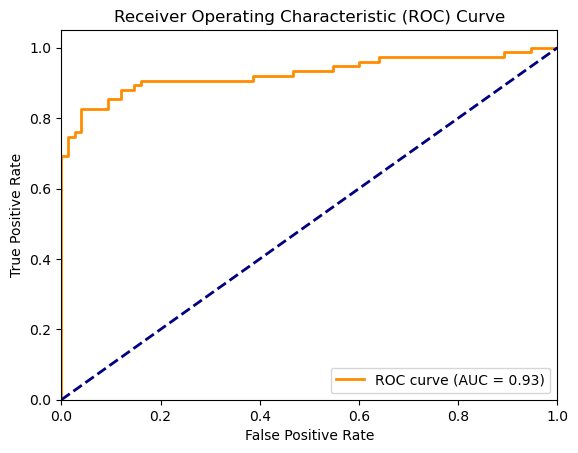

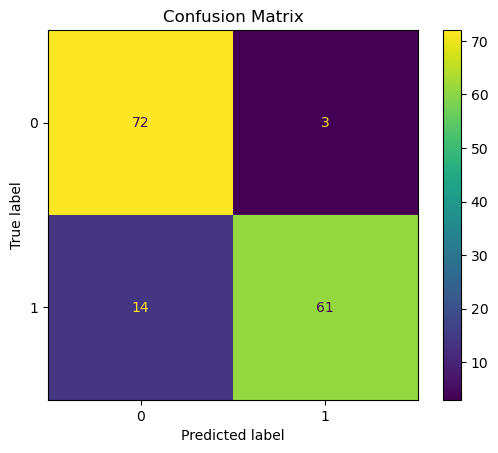

    patient_id study_instance_uid  label  prediction
0  ID_0748e0c1      ID_286183702b      0       False
1  ID_1528ff50      ID_5d0a50f3db      1        True
2  ID_07d4f582      ID_8b1137e5bc      0        True
3  ID_03131dd0      ID_a4ed78f57e      0       False
4  ID_05e0a4a1      ID_9dd14f9fa3      1        True
Bag Prediction: [False False]
Labels:  [0. 0.]
Attention Weights for Slides:
Images shape: torch.Size([60, 224, 224])


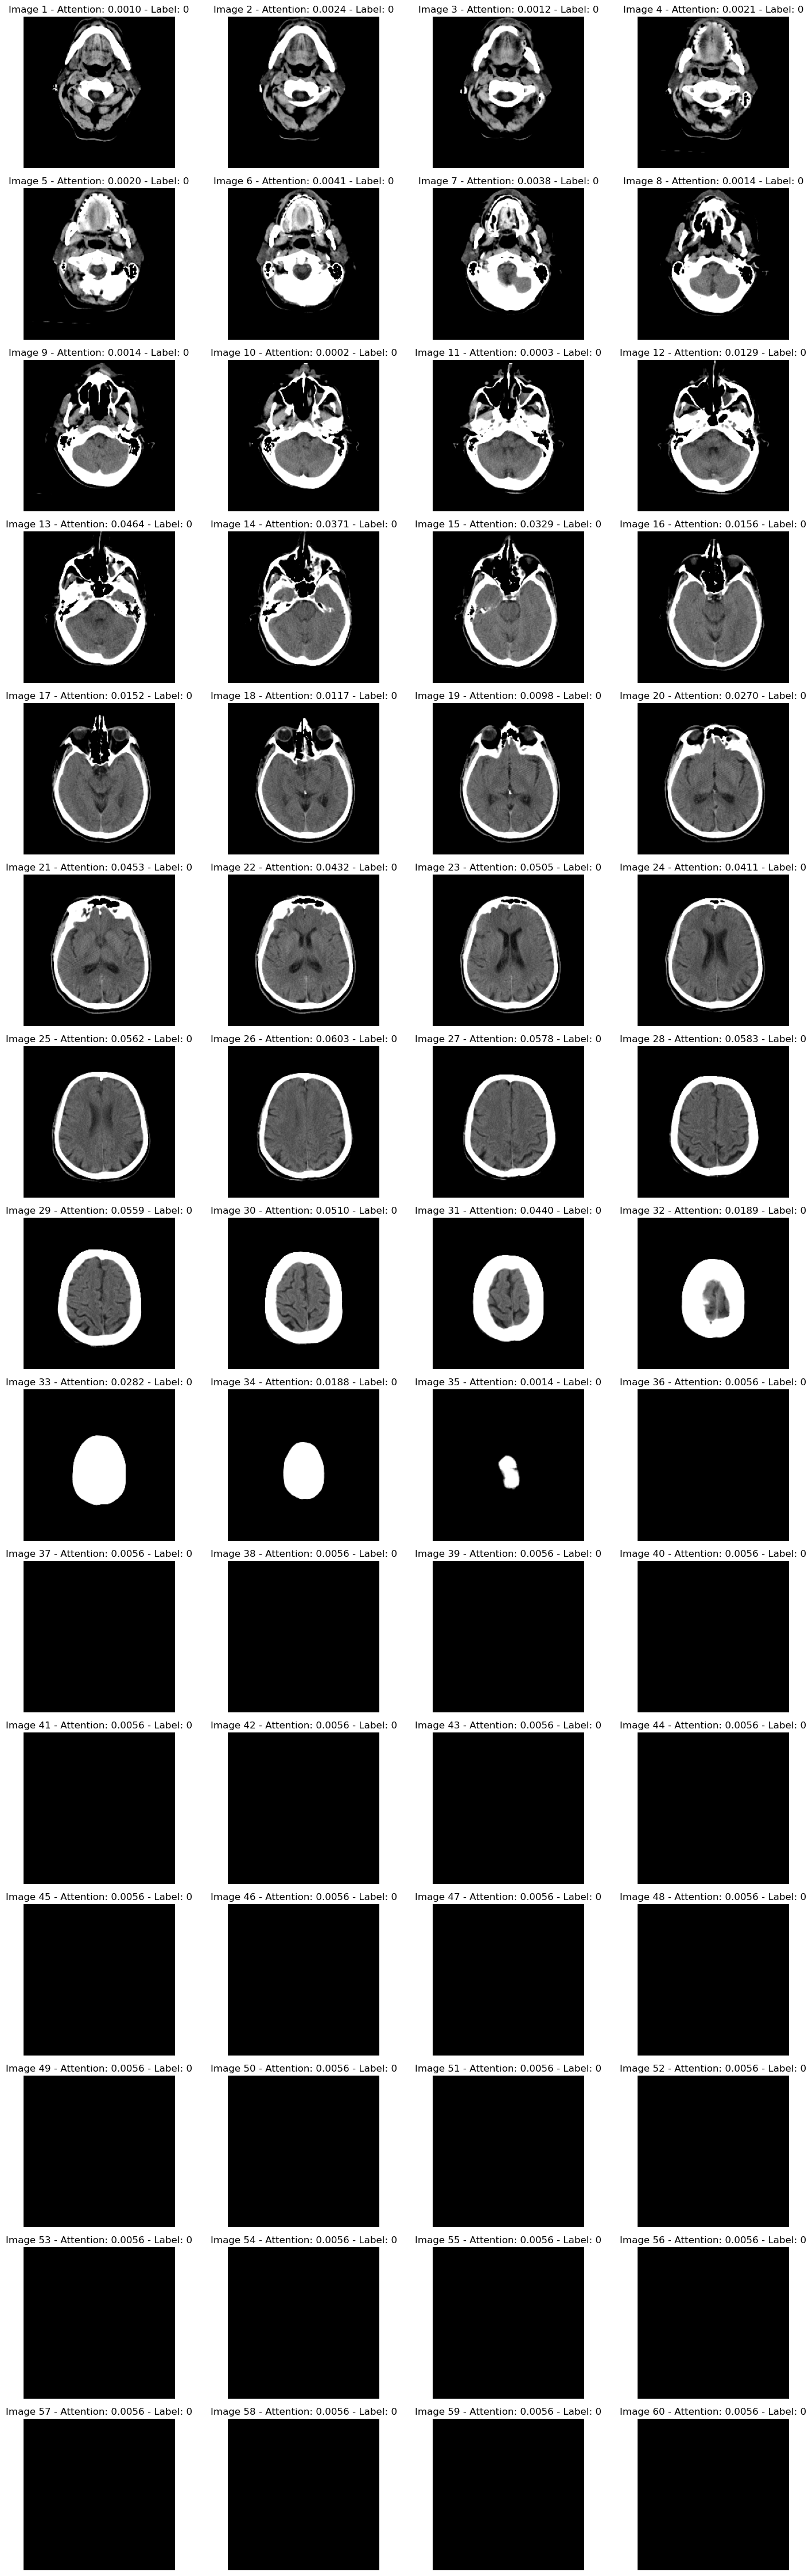

In [27]:
## Main Execution
def main(mode='train'):
    train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
    train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
    val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)
    
    # Initialize model, criterion, and optimizer
    # model = ResNet2D18_MIL()
    model = MILResNet18()
    criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss // Not used
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    if mode == 'train':
        # Train model
        trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, LEARNING_RATE, DEVICE)
        
        # Save model
        torch.save(trained_model.state_dict(), MODEL_PATH)
    
    # Load best model
    # trained_model = load_model(ResNet2D18_MIL, MODEL_PATH)
    trained_model = load_model(MILResNet18, MODEL_PATH)
    
    # Evaluate model
    predictions, labels = evaluate_model(trained_model, test_loader, DEVICE)
    metrics = calculate_metrics(predictions, labels)
    print_metrics(metrics)
    
    # Visualizations
    plot_roc_curve(trained_model, test_loader, DEVICE)
    plot_confusion_matrix(trained_model, test_loader, DEVICE)
    
    if mode == 'train':
        # Select only the required columns
        required_columns = ['patient_id', 'study_instance_uid', 'label']
        temp_test_labels = test_labels[required_columns]
        
        # Save results
        results_df = get_test_results(trained_model, test_loader, temp_test_labels)
        results_df.to_csv('results/results.csv', index=False)
        print(results_df.head())
    
    # Call the function with the test_loader
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=2)
    test_patient_bag(trained_model, test_loader)

if __name__ == "__main__":
    main(mode='train')